<h1><i>Import from Python libraries</i></h1>

In [133]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import beta

<h2><i>Matrix Factorisation</i></h2>

In [47]:
class MF():

    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]


#       Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))
                
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

<h2><i>Multi Armed Bandit</i></h2>

In [ ]:
class mab_base:
	clusters = pd.DataFrame()
	def set_clusters(self,clusters):
		self.clusters = clusters
	def init(self): #initialize all variables for your class
		pass
	def pull_arm(self, last_reward):#pull the arm, update the table
		pass
	def reset(self):
		pass

<h2><i>Thompson Sampling</i></h2>

In [75]:
class thompson(mab_base):
    
    def __init__(self):
        self.n = 0                                   # Step count
        self.mean_reward = 0                         # Total mean reward
        self.last_pick = -1                          # Previous arm pulled

    def set_clusters(self,clusters):
        self.k = clusters.shape[0]                   # Number of arms
        self.k_n = np.zeros(clusters.shape[0])       # Step count for each arm
        self.k_a = np.ones(clusters.shape[0])        # Alpha for each arm
        self.k_b = np.ones(clusters.shape[0])        # Beta for each arm
        self.k_theta = np.zeros(clusters.shape[0])   # Theta for each arm
        self.k_reward = np.zeros(clusters.shape[0])  # Mean reward for each arm
        mab_base.clusters = clusters                 # Clusters
        self.clusters_safe = clusters.copy()

    def pull_arm(self, last_reward=None):
        # update rewards and state
        lp = self.last_pick
        if (self.n > 0):
            self.k_a[lp] += last_reward
            self.k_b[lp] += 5 - last_reward

            self.k_reward[lp] = self.k_reward[lp] + (last_reward - self.k_reward[lp]) / self.k_n[lp] 
            self.mean_reward = self.mean_reward + (last_reward - self.mean_reward) / self.n 

        # cluster pick
        self.k_theta = np.random.beta(self.k_a, self.k_b)
        p = np.argmax(self.k_theta)

        # update counts and clusters
        self.n += 1
        self.k_n[[p]] += 1
        self.last_pick = p
        temp = self.clusters.iloc[p]
        temp = np.array(temp.drop('cluster'))
        rec_idx = np.argmax(temp) + 1 # +1 because the first column is for cluster name
        rec = self.clusters.columns[rec_idx]
        return rec
    
    def get_a(self):
        return self.k_a
    
    def get_b(self):
        return self.k_b

    def reset(self):
        self.n = 0
        self.k_n = np.zeros(self.clusters.shape[0])
        self.mean_reward = 0
        self.k_reward = np.zeros(self.clusters.shape[0])
        self.clusters = self.clusters_safe.copy()

In [50]:
def DCG_Normalize(dcg_pred,dcg_true):
    assert(len(dcg_true) == len(dcg_pred) )
    assert(len(dcg_true) > 0)
    ndcg = 0
    for index in range(len(dcg_true)) :
        if(dcg_true[index] != 0):
            ndcg += dcg_pred[index]/dcg_true[index]
        else:
            assert(1)
#     print(dcg_true)
    return ndcg/len(dcg_true)

def DCG_Pred_perUser(r_u_t):
    dcg = r_u_t[0]
    for time in range(len(r_u_t)) :
        if (time > 1) :
            dcg += r_u_t[time]/(math.log(time,2)) 
    return dcg

<h2><i>Reward Function</i></h2>

In [63]:
def getRewards(X_test, rec_movie,user_id):  #get true value of current user and the recommended movie/or recommended cluster
    temp = X_test.iloc[:,rec_movie:rec_movie+1]
    reward = temp[rec_movie].values[user_id]/np.max(X_test)[user_id]    
    return reward

<h2><i>Read and Merge CSV's</i></h2>

In [140]:
#STEP1: Read csvs and create nice DS out of them

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

# Merge the two files
ratings = pd.merge(movies,ratings,on='movieId')

# Creating the sparse matrix
userRatings = ratings.pivot_table(index=['userId'],columns=['movieId'],values='rating').fillna(0)
userRatings.head()
print(userRatings)

# Creating predicted rating matrix
R = userRatings.values

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     0.0     4.0     0.0     0.0     4.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...         ...     ...     ...     ...     ...     ...     ...     ...   
606         2.5     0.0     0.0     0.0     0.0     0.0     2.5     0.0   
607         4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
608         2.5     2.0     2.0     0.0     0.0     0.0     0.0     0.0   
609         3.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
610         5.0     0.0     0.0     0.0     0.0     5.0     0.0     0.0   

movieId  9       10     

In [53]:
#Creating the Collab filtering object
mf = MF(R, K=5, alpha=0.1, beta=0.01, iterations=1)

training_process = mf.train()

final_predicted_matrix = pd.DataFrame(mf.full_matrix())
print(final_predicted_matrix)

         0         1         2         3         4         5         6     \
0    3.567457  3.295020  3.615802  3.555306  3.440206  3.474794  3.368869   
1    3.748801  3.379572  3.703372  3.541058  3.546161  3.520444  3.481179   
2    3.477021  3.572215  3.395897  3.419442  3.556583  3.439741  3.482183   
3    3.554851  3.542964  3.493431  3.463736  3.530849  3.501270  3.550790   
4    3.518158  3.346890  3.583620  3.581478  3.435562  3.448214  3.346040   
..        ...       ...       ...       ...       ...       ...       ...   
605  3.451330  3.575624  3.444578  3.446649  3.537593  3.567448  3.609045   
606  3.458942  3.287851  3.579629  3.611028  3.379627  3.435410  3.290917   
607  3.627088  3.700492  3.476081  3.492212  3.462367  3.455859  3.668172   
608  3.376014  3.273526  3.546970  3.590194  3.392185  3.483778  3.304003   
609  3.421956  3.595602  3.392118  3.415600  3.575955  3.524744  3.556997   

         7         8         9     ...      9714      9715      9716  \
0  

<h3><i>calculate number of clusters required</i></h3>

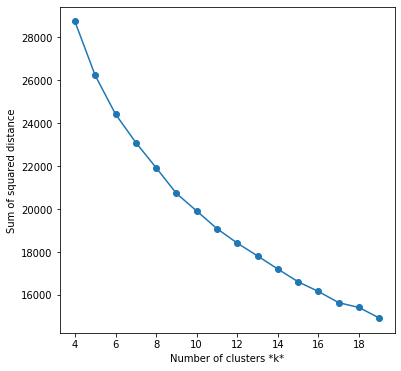

In [70]:
sse = []
list_k = list(range(4, 20))
X_train, X_test = train_test_split(final_predicted_matrix, test_size=0.1)

for k in list_k:
    km = KMeans(n_clusters=k,n_init = 20, n_jobs=-1)
    km.fit(X_train)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters (k)')
plt.ylabel('Sum of squared error (SSE)');

<h2><i>Parameters</i></h2>

In [ ]:
T = 5                 #Number of iterations for a given run
N = 20                #Number of runs
k_alpha=[]            #All values of alpha
k_beta=[]             #All values of beta

dcg_thom=[]
dcg_thom_true=[]

<h2><i>Recommendation System</i></h2>

0
Done
Movie Recommended:	325

[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]


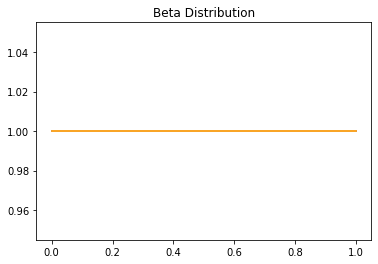

Movie Recommended:	8853

[1.         1.         1.         1.         1.91007153 1.
 1.         1.        ]
[1.         1.         1.         1.         5.08992847 1.
 1.         1.        ]


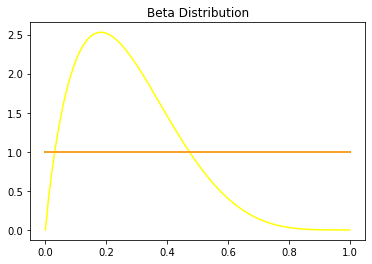

Movie Recommended:	2397

[1.         1.         1.         1.94404596 1.91007153 1.
 1.         1.        ]
[1.         1.         1.         5.05595404 5.08992847 1.
 1.         1.        ]


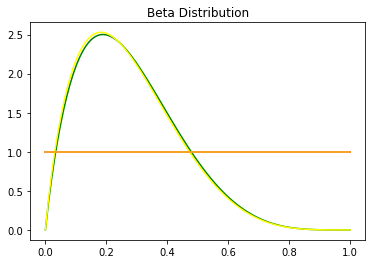

Movie Recommended:	3604

[1.         1.         1.         1.94404596 1.91007153 1.9448207
 1.         1.        ]
[1.         1.         1.         5.05595404 5.08992847 5.0551793
 1.         1.        ]


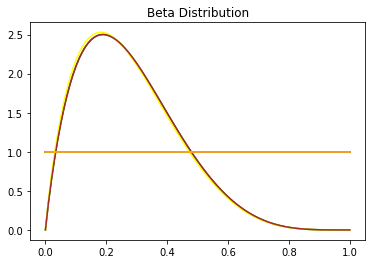

Movie Recommended:	6597

[1.         1.         1.91972056 1.94404596 1.91007153 1.9448207
 1.         1.        ]
[1.         1.         5.08027944 5.05595404 5.08992847 5.0551793
 1.         1.        ]


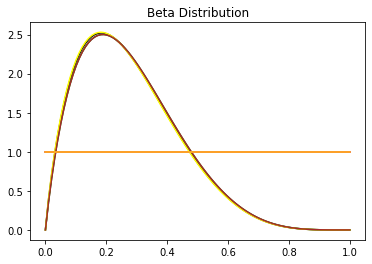

Movie Recommended:	3612

[1.         1.         1.91972056 1.94404596 1.91007153 1.9448207
 1.9373694  1.        ]
[1.         1.         5.08027944 5.05595404 5.08992847 5.0551793
 5.0626306  1.        ]


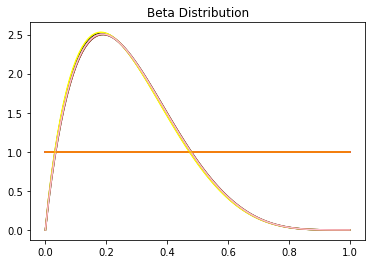

Movie Recommended:	4280

[1.90032708 1.         1.91972056 1.94404596 1.91007153 1.9448207
 1.9373694  1.        ]
[5.09967292 1.         5.08027944 5.05595404 5.08992847 5.0551793
 5.0626306  1.        ]


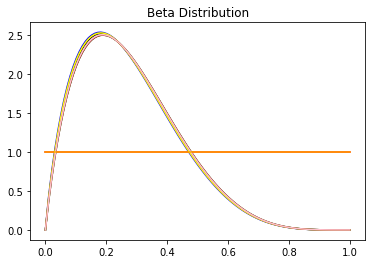

Movie Recommended:	5926

[1.90032708 1.         1.91972056 1.94404596 1.91007153 1.9448207
 1.9373694  1.96937357]
[5.09967292 1.         5.08027944 5.05595404 5.08992847 5.0551793
 5.0626306  5.03062643]


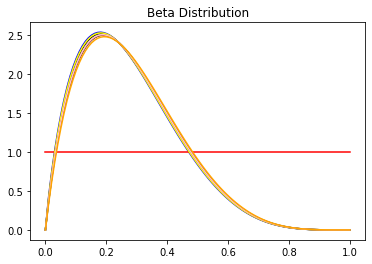

Movie Recommended:	325

[1.90032708 2.05269605 1.91972056 1.94404596 1.91007153 1.9448207
 1.9373694  1.96937357]
[5.09967292 4.94730395 5.08027944 5.05595404 5.08992847 5.0551793
 5.0626306  5.03062643]


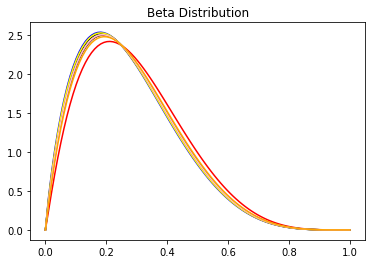

Movie Recommended:	3612

[1.90032708 2.05269605 1.91972056 1.94404596 2.87808971 1.9448207
 1.9373694  1.96937357]
[5.09967292 4.94730395 5.08027944 5.05595404 9.12191029 5.0551793
 5.0626306  5.03062643]


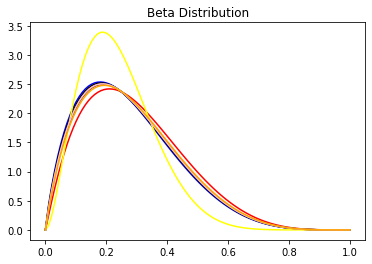

Movie Recommended:	5926

[2.83783597 2.05269605 1.91972056 1.94404596 2.87808971 1.9448207
 1.9373694  1.96937357]
[9.16216403 4.94730395 5.08027944 5.05595404 9.12191029 5.0551793
 5.0626306  5.03062643]


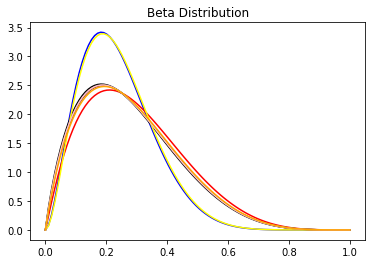

Movie Recommended:	8853

[2.83783597 2.96552637 1.91972056 1.94404596 2.87808971 1.9448207
 1.9373694  1.96937357]
[9.16216403 9.03447363 5.08027944 5.05595404 9.12191029 5.0551793
 5.0626306  5.03062643]


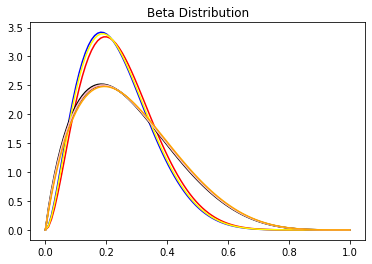

Movie Recommended:	2397

[2.83783597 2.96552637 1.91972056 2.86247146 2.87808971 1.9448207
 1.9373694  1.96937357]
[9.16216403 9.03447363 5.08027944 9.13752854 9.12191029 5.0551793
 5.0626306  5.03062643]


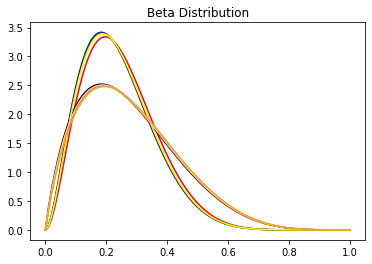

Movie Recommended:	5926

[2.83783597 2.96552637 1.91972056 2.86247146 2.87808971 2.87030511
 1.9373694  1.96937357]
[9.16216403 9.03447363 5.08027944 9.13752854 9.12191029 9.12969489
 5.0626306  5.03062643]


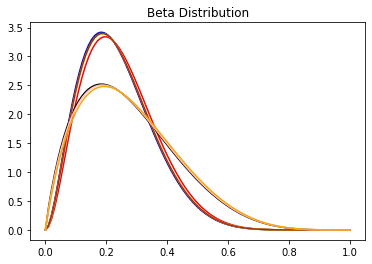

Movie Recommended:	3604

[2.83783597 3.88391118 1.91972056 2.86247146 2.87808971 2.87030511
 1.9373694  1.96937357]
[ 9.16216403 13.11608882  5.08027944  9.13752854  9.12191029  9.12969489
  5.0626306   5.03062643]


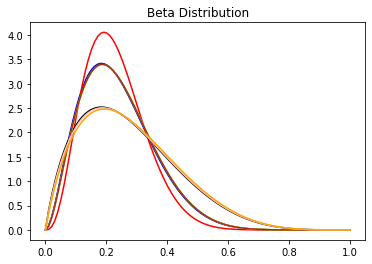

Movie Recommended:	8853

[2.83783597 3.88391118 2.82278833 2.86247146 2.87808971 2.87030511
 1.9373694  1.96937357]
[ 9.16216403 13.11608882  9.17721167  9.13752854  9.12191029  9.12969489
  5.0626306   5.03062643]


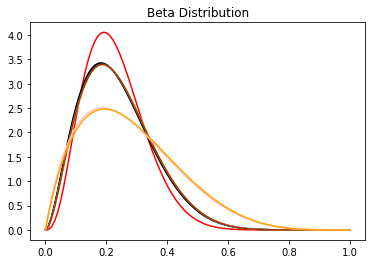

Movie Recommended:	325

[2.83783597 3.88391118 2.82278833 3.85877376 2.87808971 2.87030511
 1.9373694  1.96937357]
[ 9.16216403 13.11608882  9.17721167 13.14122624  9.12191029  9.12969489
  5.0626306   5.03062643]


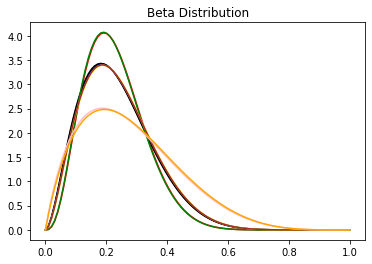

Movie Recommended:	6597

[2.83783597 3.88391118 2.82278833 3.85877376 3.92338561 2.87030511
 1.9373694  1.96937357]
[ 9.16216403 13.11608882  9.17721167 13.14122624 13.07661439  9.12969489
  5.0626306   5.03062643]


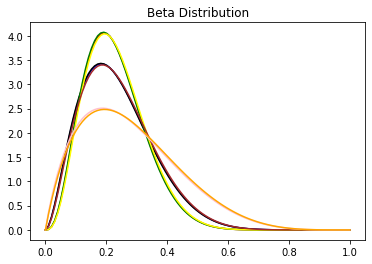

Movie Recommended:	8853

[2.83783597 3.88391118 2.82278833 3.85877376 3.92338561 2.87030511
 2.91758069 1.96937357]
[ 9.16216403 13.11608882  9.17721167 13.14122624 13.07661439  9.12969489
  9.08241931  5.03062643]


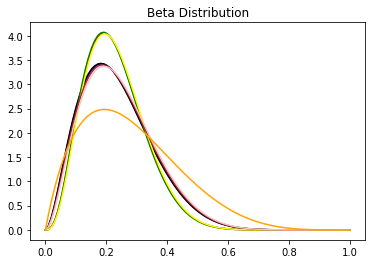

Movie Recommended:	3604

[2.83783597 3.88391118 2.82278833 4.81793513 3.92338561 2.87030511
 2.91758069 1.96937357]
[ 9.16216403 13.11608882  9.17721167 17.18206487 13.07661439  9.12969489
  9.08241931  5.03062643]


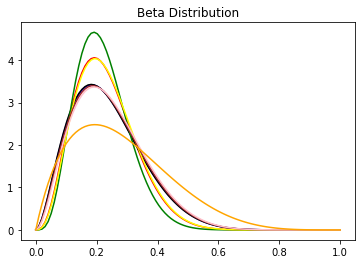

In [102]:
for i in range(0,1):
    #split train and test dataset
    X_train, X_test = train_test_split(final_predicted_matrix, test_size=0.1)

    #cluster the train dataset
    model_knn = KMeans(n_clusters=8, n_init = 20, random_state = 42, n_jobs=-1)
    model_knn.fit(X_train)
    y_km = model_knn.fit_predict(X_train)
    final_clusters = model_knn.cluster_centers_
    final_clusters = pd.DataFrame(final_clusters)      # Final Clusters

    # Creating a new initial column with name 'cluster'
    new_col = {'cluster': [i for i in range(1,len(final_clusters)+1)]}
    new_col = pd.DataFrame(new_col)
    final_clusters = new_col.join(final_clusters)

    # create thompson mab object
    r_u_t_thom  = []
    r_u_t_thom_true  = []

    mab = thompson()    
    mab.set_clusters(final_clusters)
    
    last_reward = 0
    
    
    for i in range(0,T):
        # pull arm
        print('')
        print("Movie Recommended:\t", end='')
        rec_movie_id = mab.pull_arm(last_reward)
        print(rec_movie_id)
        print('')
        
        #rewards
        shape_test=X_test.shape[0]
        user_id=np.random.randint(0,shape_test)
        last_reward = getRewards(X_test,rec_movie_id,user_id) 
        
        temp = X_test.iloc[:,rec_movie_id:rec_movie_id+1]
        r_u_t_thom.append(temp[rec_movie_id].values[0])
        r_u_t_thom_true.append(np.max(X_test,axis =1).values[0])
        
        #get alpha, beta values
        k_alpha=mab.get_a()
        k_beta=mab.get_b()
        print(k_alpha)
        print(k_beta)
        x=np.linspace(0,1,100)
        a=beta.pdf(x,k_alpha[0],k_beta[0])
        b=beta.pdf(x,k_alpha[1],k_beta[1])
        d=beta.pdf(x,k_alpha[2],k_beta[2])
        e=beta.pdf(x,k_alpha[3],k_beta[3])
        f=beta.pdf(x,k_alpha[4],k_beta[4])
        g=beta.pdf(x,k_alpha[5],k_beta[5])
        h=beta.pdf(x,k_alpha[6],k_beta[6])
        i=beta.pdf(x,k_alpha[7],k_beta[7])
        
        #beta distribution
        plt.plot(x,a,c="blue")
        plt.plot(x,b,c='red')
        plt.plot(x,d,c='black')
        plt.plot(x,e,c='green')
        plt.plot(x,f,c="yellow")
        plt.plot(x,g,c='brown')
        plt.plot(x,h,c='pink')
        plt.plot(x,i,c='orange')
        plt.xlabel("theta")
        plt.ylabel("probabilty Density Function(PDF)")
        plt.title("Beta Distribution")
        plt.show()

    dcg_thom.append(DCG_Pred_perUser(r_u_t_thom))
    dcg_thom_true.append(DCG_Pred_perUser(r_u_t_thom_true))

    # reset
    mab_0.reset()

<h2><i>Plotting Beta Distribution</i></h2>

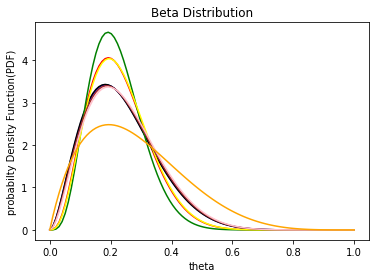

In [141]:
x=np.linspace(0,1,100)
a=beta.pdf(x,k_alpha[0],k_beta[0])
b=beta.pdf(x,k_alpha[1],k_beta[1])
d=beta.pdf(x,k_alpha[2],k_beta[2])
e=beta.pdf(x,k_alpha[3],k_beta[3])
f=beta.pdf(x,k_alpha[4],k_beta[4])
g=beta.pdf(x,k_alpha[5],k_beta[5])
h=beta.pdf(x,k_alpha[6],k_beta[6])
i=beta.pdf(x,k_alpha[7],k_beta[7])


plt.plot(x,a,c="blue")
plt.plot(x,b,c='red')
plt.plot(x,d,c='black')
plt.plot(x,e,c='green')
plt.plot(x,f,c="yellow")
plt.plot(x,g,c='brown')
plt.plot(x,h,c='pink')
plt.plot(x,i,c='orange')
plt.xlabel("theta")
plt.ylabel("probabilty Density Function(PDF)")
plt.title("Beta Distribution")
plt.show()

In [105]:
ndg_thom = DCG_Normalize(dcg_thom,dcg_thom_true)
print("NDCG for Thompson Algorithm for ",N, "users over time ",T, ": ", ndg_thom)

NDCG for Thompson Algorithm for  20 users over time  20 :  0.9129528519447371


<h2><i>NDCG values for different N and T</i></h2>

In [121]:
N=[10,15,20]
T=[5,10,15]
NDCG=[]

In [122]:
for j in range(0,3):
    for k in range(0,3):
        dcg_thom=[]
        dcg_thom_true=[]
        for i in range(0,N[j]):
            #split train and test dataset
            X_train, X_test = train_test_split(final_predicted_matrix, test_size=0.1)

            #cluster the train dataset
            model_knn = KMeans(n_clusters=8, n_init = 20, random_state = 42, n_jobs=-1)
            model_knn.fit(X_train)
            y_km = model_knn.fit_predict(X_train)
            final_clusters = model_knn.cluster_centers_
            final_clusters = pd.DataFrame(final_clusters)       # Final Clusters

            # Creating a new initial column with cluster name
            new_col = {'cluster': [i for i in range(1,len(final_clusters)+1)]}
            new_col = pd.DataFrame(new_col)
            final_clusters = new_col.join(final_clusters)

            # create thompson mab object
            r_u_t_thom  = []
            r_u_t_thom_true  = []

            mab = thompson()    
            mab.set_clusters(final_clusters)
            
            last_reward = 0
            
            for t in range(0,T[k]):
                rec_movie_id = mab.pull_arm(last_reward)
                shape_test=X_test.shape[0]
                user_id=np.random.randint(0,shape_test)
                last_reward = getRewards(X_test,rec_movie_id,user_id) 
                temp = X_test.iloc[:,rec_movie_id:rec_movie_id+1]
                r_u_t_thom.append(temp[rec_movie_id].values[0])
                r_u_t_thom_true.append(np.max(X_test,axis =1).values[0])

            dcg_thom.append(DCG_Pred_perUser(r_u_t_thom))
            dcg_thom_true.append(DCG_Pred_perUser(r_u_t_thom_true))

            # reset
            mab_0.reset()
        ndg_thom = DCG_Normalize(dcg_thom,dcg_thom_true)
        NDCG.append(ndg_thom)
        print(ndg_thom)

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
0.9119839608920003
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
0.9193364674068949
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
0.9293292227316433
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
0.9137092685536348
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
0.915042410633018
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
0.9259161221382051
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
0.9131238075011485
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
0.9138309067672548
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
0.9093560177946776


In [124]:
NDCG


[0.9119839608920003,
 0.9193364674068949,
 0.9293292227316433,
 0.9137092685536348,
 0.915042410633018,
 0.9259161221382051,
 0.9131238075011485,
 0.9138309067672548,
 0.9093560177946776]

In [125]:
label=["{10,5}","{10,10}","{10,15}","{15,5}","{15,10}","{15,15}","{20,5}","{20,10}","{20,15}"]

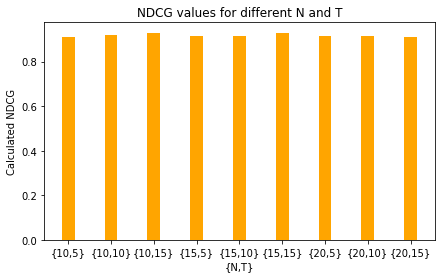

In [150]:
fig = plt.figure(figsize = (7, 4))
plt.bar(label, NDCG, color ='orange',width = 0.3)

plt.xlabel("{N,T}")
plt.ylabel("Calculated NDCG")
plt.title("NDCG values for different N and T")
plt.show()